# Online Retail Dataset EDA

## Objective:
- Understand structure
- Identify missing values
- Explore relationships

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
df = pd.read_csv("../data/raw/online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Dataset overview

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Missing values handling

The dataset contains a significant number of missing values in the `CustomerID` column.
Since customer segmentation requires aggregating transactions at the customer level,
records without a customer identifier cannot be used and will be removed from further analysis.

Missing values in the `Description` column are not critical for the RFM-based approach and
will be retained, as this feature is not used in customer-level aggregation.

Missing values are handled based on their impact on customer-level aggregation rather than blindly imputing values. These steps will be implemented in the preprocessing pipeline to ensure reproducibility.

## Quantity distribution

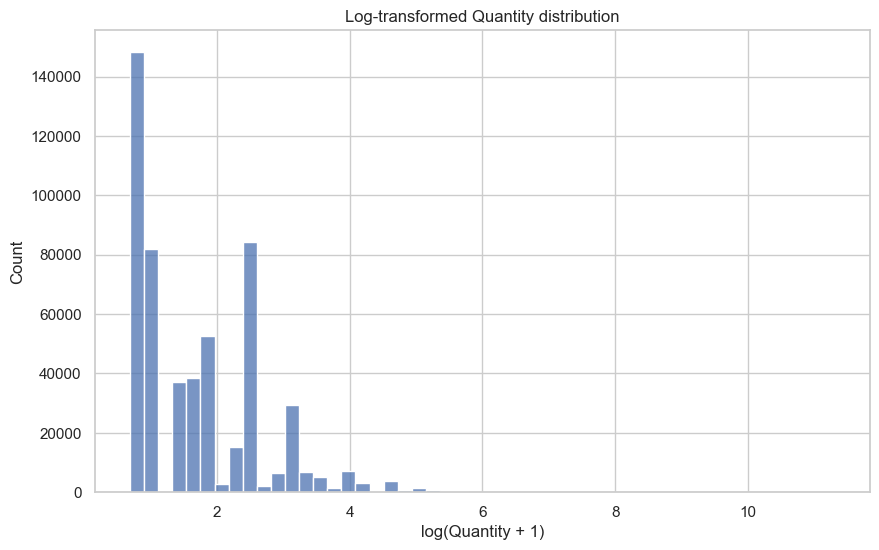

In [7]:
qty = df.loc[df["Quantity"] > 0, "Quantity"]

sns.histplot(np.log1p(qty), bins=50)
plt.title("Log-transformed Quantity distribution")
plt.xlabel("log(Quantity + 1)")
plt.show()

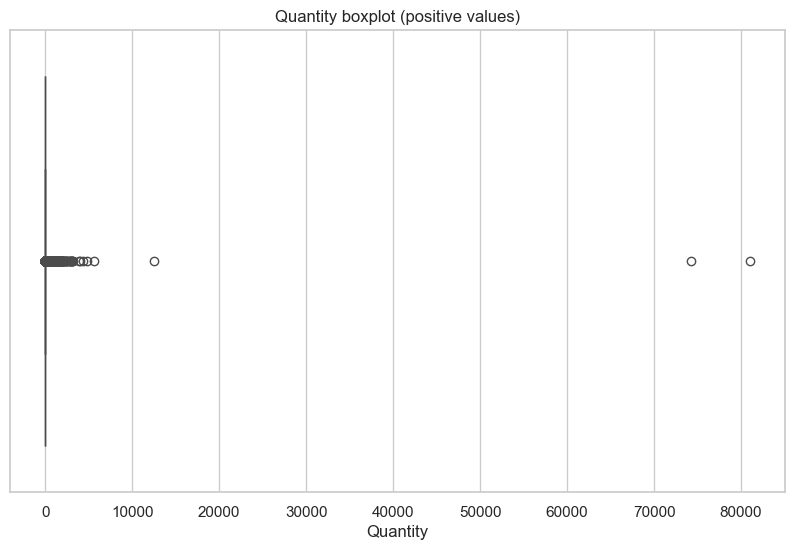

In [8]:
sns.boxplot(x=qty)
plt.title("Quantity boxplot (positive values)")
plt.show()

### The distribution of quantity is highly skewed with extreme outliers. While the raw distribution is not very informative on its own, it highlights the need for log transformation and outlier handling during preprocessing.

## Total price analysis

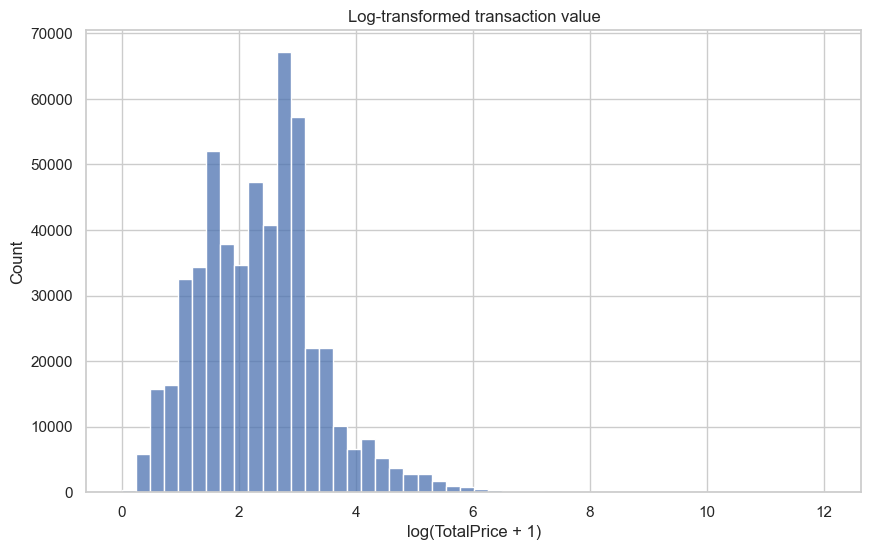

In [9]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
tp = df.loc[df["TotalPrice"] > 0, "TotalPrice"]

sns.histplot(np.log1p(tp), bins=50)
plt.title("Log-transformed transaction value")
plt.xlabel("log(TotalPrice + 1)")
plt.show()

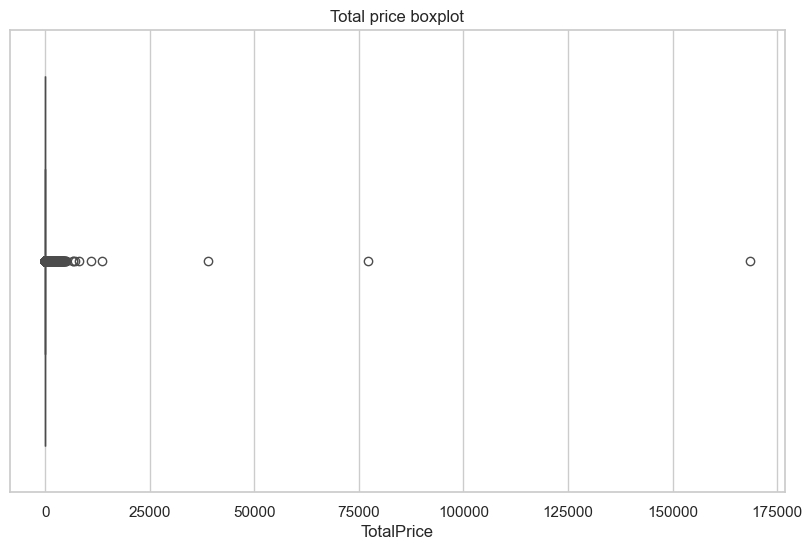

In [10]:
sns.boxplot(x=tp)
plt.title("Total price boxplot")
plt.show()

### The distribution of transaction values is strongly right-skewed, with a small number of high-value transactions contributing disproportionately to total revenue. Logarithmic transformation improves visualization and highlights the long-tail nature of the data. These characteristics indicate that customer-level aggregation and outlier-aware preprocessing are required for effective segmentation.


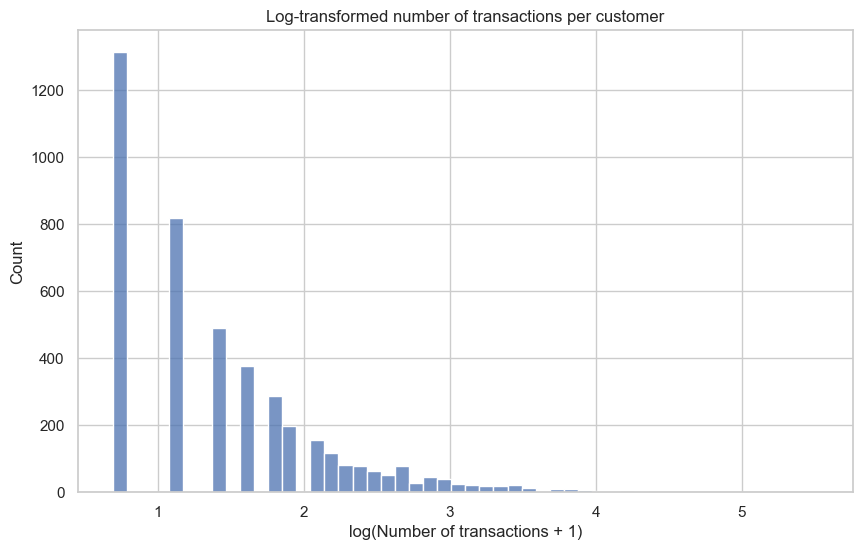

In [11]:
tx_per_customer = (
    df.dropna(subset=["CustomerID"])
      .groupby("CustomerID")["InvoiceNo"]
      .nunique()
)

sns.histplot(np.log1p(tx_per_customer), bins=50)
plt.title("Log-transformed number of transactions per customer")
plt.xlabel("log(Number of transactions + 1)")
plt.ylabel("Count")
plt.show()

### The distribution of transaction frequency per customer is highly skewed. Most customers make only a small number of purchases, while a small group accounts for frequent buying behavior. This supports the use of frequency as a key feature in customer segmentation.

c:\Users\juras\Desktop\python_projects\venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


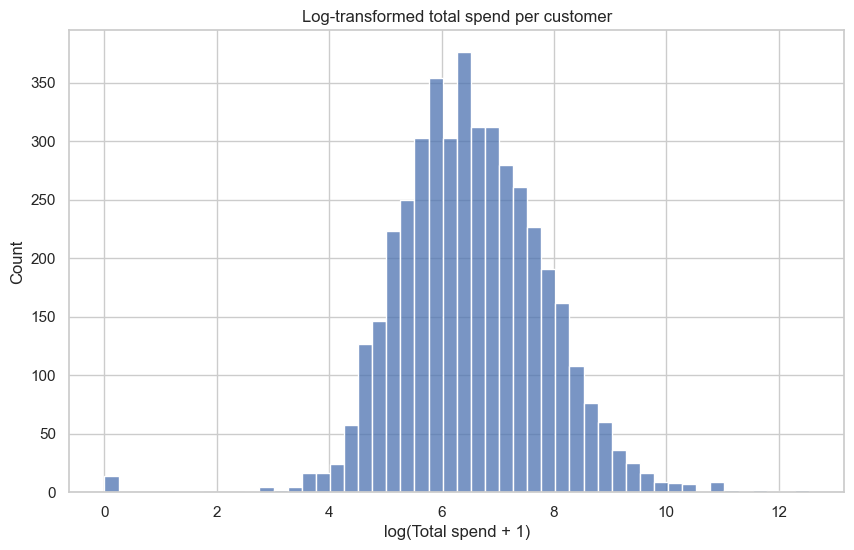

In [14]:
monetary_per_customer = (
    df.dropna(subset=["CustomerID"])
      .groupby("CustomerID")["TotalPrice"]
      .sum()
)

sns.histplot(np.log1p(monetary_per_customer), bins=50)
plt.title("Log-transformed total spend per customer")
plt.xlabel("log(Total spend + 1)")
plt.ylabel("Count")
plt.show()

### Customer monetary value exhibits a strong long-tail distribution, with a small number of high-value customers contributing disproportionately to total revenue. This confirms the relevance of monetary value as a core segmentation feature.

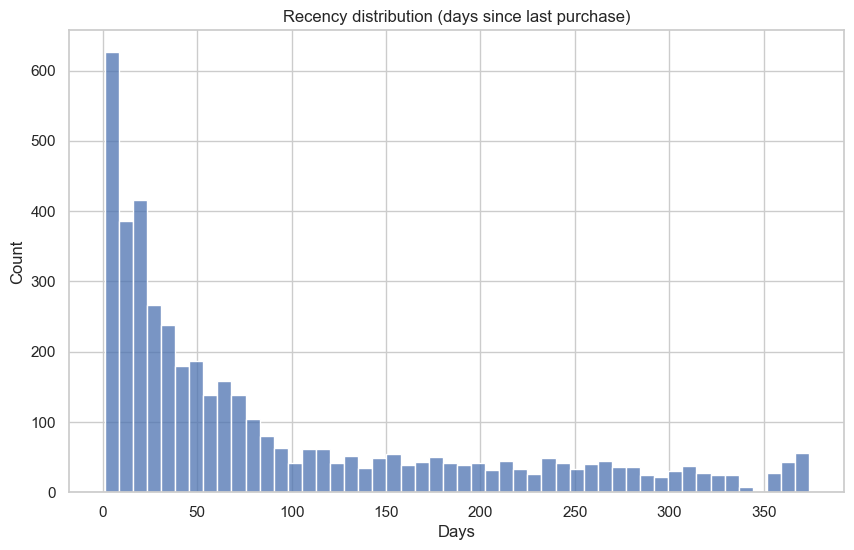

In [15]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

recency = (
    df.dropna(subset=["CustomerID"])
      .groupby("CustomerID")["InvoiceDate"]
      .max()
)
recency_days = (snapshot_date - recency).dt.days

sns.histplot(recency_days, bins=50)
plt.title("Recency distribution (days since last purchase)")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

### Recency values indicate clear differences between recently active customers and those who have not made purchases for an extended period. This feature is expected to play an important role in identifying inactive or churn-prone segments.

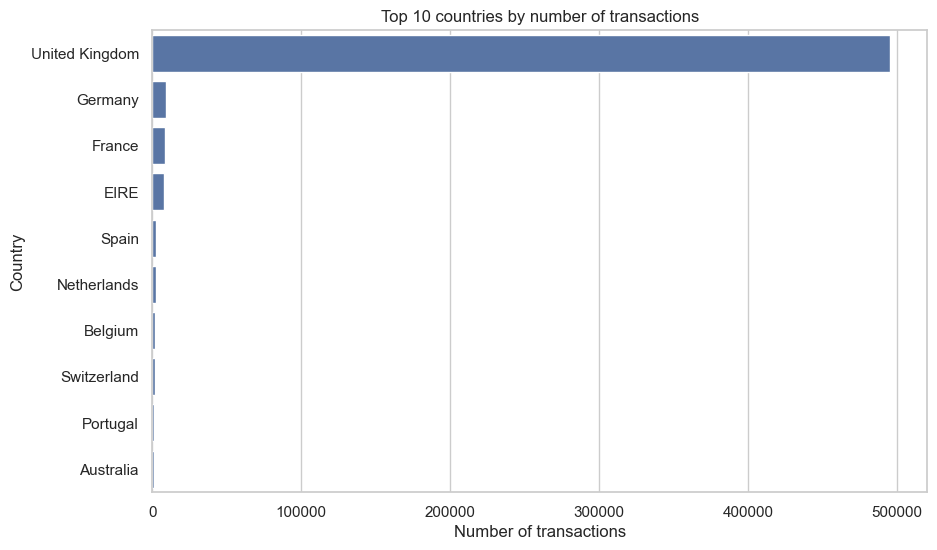

In [16]:
top_countries = (
    df["Country"]
    .value_counts()
    .head(10)
)

sns.barplot(
    x=top_countries.values,
    y=top_countries.index
)
plt.title("Top 10 countries by number of transactions")
plt.xlabel("Number of transactions")
plt.ylabel("Country")
plt.show()

### The dataset is heavily dominated by transactions from the United Kingdom. This observation may justify focusing the segmentation analysis on a single country to reduce noise caused by regional differences.

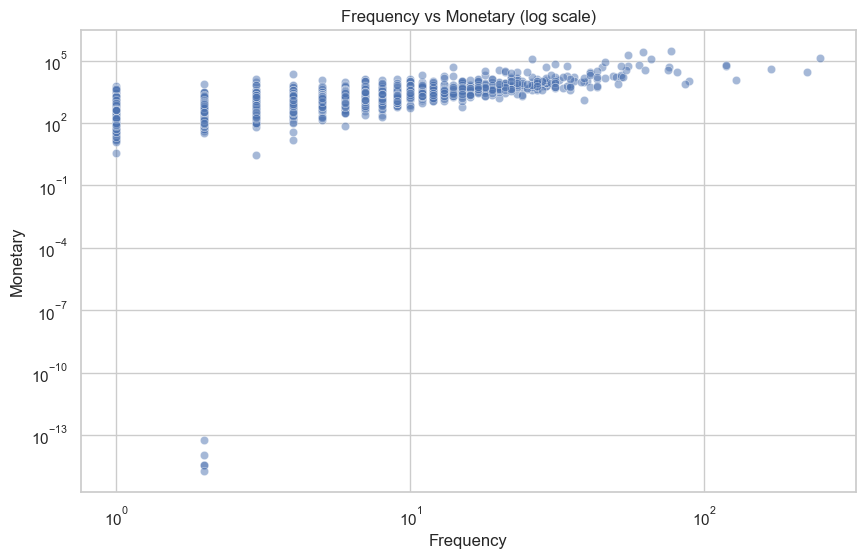

In [17]:
rfm_eda = pd.DataFrame({
    "Frequency": tx_per_customer,
    "Monetary": monetary_per_customer
})

sns.scatterplot(
    data=rfm_eda,
    x="Frequency",
    y="Monetary",
    alpha=0.5
)
plt.xscale("log")
plt.yscale("log")
plt.title("Frequency vs Monetary (log scale)")
plt.show()


### The scatter plot reveals distinct behavioral patterns among customers, suggesting that clustering based on frequency and monetary value is likely to produce meaningful segments.

## Key ingormation
- Customer value is highly unevenly distributed, suggesting the presence of distinct
  high-value and low-value customer groups.
- Most customers purchase infrequently, while a small segment exhibits repeated
  purchasing behavior.
- Recency highlights clear differences between currently active customers and those
  who may be at risk of churn.
- Log-transformed monetary features are well-suited for clustering and reduce the
  influence of extreme outliers.
- RFM-based aggregation captures key behavioral patterns and enables interpretable
  customer segmentation.